<a href="https://colab.research.google.com/github/christianhidber/easyagents/tree/master/jupyter_notebooks/easyagents_line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Line World

* an agent lives in a finite linear world of uneven elements
* at each moment it is in a certain position
* initial position is the middle
* some positions gain rewards, some don't
* rewards are between 0 and 15
* agent can either move left or right
* Objective: maximize total reward = sum(rewards) + sum(steps)
* Cost per step: -1
* Done Condition: agent is at pos 0 or total reward <= -20

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/rl/line-world.png?raw=1'>

## TODO
1. Wie machen wir es mit sich entwickelnden Environments? Version hochzählen wie hier?
  * Der easy agent scheint nicht klar zu kommen mit mehr einem wechselnden Environment
1. OZ->CHH: Wie geht das mit dem einklinken in das Rendering, bin hier überfordert, Hilfe!
1. Version mit Lücken für die Übung erstellen


### Install gym, tensorflow, tf-agents,..., setup display

In [0]:
!pip install -q easyagents
!pip install -q networkx==2.3.0 

##### suppress package warnings, in colab: load additional packages for rendering

In [2]:
import sys
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
if 'google.colab' in sys.modules:
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start() 

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


# Define Gym Environment

## What you need to define
1. Actions
1. Observation
1. Reward
1. Game done?

## Remember how an environment looks like

```python
class MyEnv(gym.Env):
  def __init__(self):
      # set up the environment

    def step(self, action):
        # make the action have an impact on the environment
        # and return the information the algorithms need
        return observation, reward, done, info

    def reset(self):
        # reset this environment to the initial state and return the according observation
        return observation

    def render(self, mode='ansi'):
        # spits out a human readable rendering of the environment
        if mode == 'ansi':
            return self._render_ansi()
        elif mode == 'rgb_array':
            return self._render_rgb()
        else:
            super().render(mode=mode)
  
```

https://gym.openai.com/

https://github.com/openai/gym/blob/master/docs/creating-environments.md

## Applying Reinforcement Learning to a problem

* Is your problem approachable by Reinforcement Learning (more on that later)?
  * Can you defined what would be the agent and what the environment?
* You can simulate your environment or are able to safely perform a large number of experiments in the real world
* You need to be able to define your problem as a Markov Decision Process (MDP)
* Good sanity check: Would you as a human be able to play the game based on the observation and reward you get?
* there are different kinds of observations
  * fully observed environment (e.g. Jump'n'Run Game)
  * partially observed environment (e.g. Ego Shooter)
* Choose a proper Reinforcement Learning Algorithm (more on that later)

## MDP: Markov Decision Process in Reinforcement Learning

* https://en.wikipedia.org/wiki/Markov_decision_process
* Model your observation in a way that which actions the agent took to get to a certain state are irrelevant
* That means all information necessary to derive a proper action need to be in a single observation
* The agents must not be forced to also learn the sequence of observations
* E.g. the position of the PacMan is not enough. Which path taken results in where the ghosts are and what pills have been eaten

In [0]:
version = 0

In [0]:
import numpy as np
import math

import gym
from gym import error, spaces, utils

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

LEFT = 0
RIGHT = 1

class LineWorldEnv(gym.Env):

    # constructor sets up the properties of the environment
    # most important action space, observation space and reward range
    def __init__(self, state=[10, 0, 0, 5, 0, 2, 15]):
        self.state = np.array(state)
        # the agent can perform  different actions
        number_of_actions = 2
        self.action_space = spaces.Discrete(number_of_actions)

        self.size_of_world = len(state)

        ### OZ->CHH: Hier würden wir was hinschreiben, damit es zur Observation passt, das müssten die Teilnehmer dann ebenfalls umbauen
        # Für observation gleiche Werte für alles

        # Observation size = 5
        # Min = 0
        # Max = 10

        # Constante rein in v0

        # Ableiten von State in get observation

        # Plot arbeitet auf State, nicht observation

        # the environment's state is described by the position of the agent and the remaining rewards
        low = np.append([0], np.full(self.size_of_world, 0))
        high = np.append([self.size_of_world - 1], np.full(self.size_of_world, 15))
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)

        self.reward_range = (-1, 1)
        # 32 is only theoretical, because we need to travel at least 9 steps, leaving us with 23 practically
        self.optimum = self.state.sum() - 9

        self._figure = None

        self.reset()

    # OZ->CHH: Für die Übung würde hier nur ein flaches np.array herauskommen mit Nullen drin, geht dann natürlich nicht 
    def get_observation(self):
        return np.append([self.pos], self.remaining_rewards)

    def reset(self):
        self.total_reward = 0
        self.done = False
        self.pos = math.floor(len(self.state) / 2)
        self.steps = 0

        self.remaining_rewards = np.array(self.state, copy=True)
        return self.get_observation()

    def step(self, action):
        if action == LEFT and self.pos != 0:
          self.pos -= 1
        elif self.pos < self.size_of_world -1:
          self.pos += 1

        reward = self.remaining_rewards[self.pos] - 1
        normalized_reward = reward / self.optimum
        self.total_reward += normalized_reward
        self.remaining_rewards[self.pos] = 0

        if self.pos == 0 or self.total_reward * self.optimum <= -20:
          self.done = True
        self.steps += 1

        observation = self.get_observation()
        info = None
        return observation, normalized_reward, self.done, info

    def _render_ansi(self):
        return 'position: {position}, remaining rewards: {rewards}, total reward so far: {total}, normalized total reward: {normalized_total}, steps so far: {steps}, game done: {done}'.format(
            position=self.pos, 
            rewards=self.remaining_rewards, 
            total=self.total_reward * self.optimum, 
            normalized_total = self.total_reward,
            done=self.done,
            steps=self.steps)              

    def _render_to_figure(self):
        """ Renders the current state as a graph with matplotlib
        """
        # draw graph using matplotlib
        if (self._figure is not None):
            plt.close(self._figure)
        self._figure, ax = plt.subplots(1, figsize=(8, 4))
        
        x = np.arange(0, self.size_of_world, 1, dtype=np.uint8)
        y = self.remaining_rewards
        plt.plot([self.pos, self.pos], [0, 2], 'r^-')
        ax.scatter(x, y, s=75)
        
        self._figure.canvas.draw()
        # OZ->CHH: Help! 
        plt.show()


    def render(self, mode='ansi'):
        if mode == 'ansi':
            return self._render_ansi()
        elif mode == 'rgb_array':
            self._render_to_figure()
        else:
            super().render(mode=mode)


# Hands-On 1: Try out our environment

_use yourself to simulate the agent_

* Create an environment and play the game to the end manually using the cells below
* Use a sequence of left and right commands to find the best solution possible
* Show yourself only local observations and reward for each step and choose an action
* Would this be sufficent for a good reward?
* What reward do you get? What is the optimum?

In [0]:
env = LineWorldEnv()

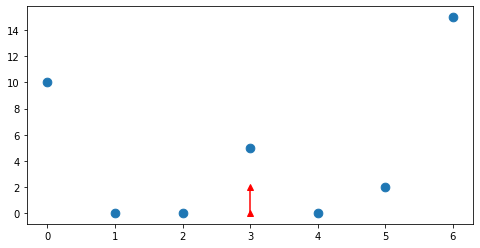

In [6]:
env.render(mode='rgb_array')

In [7]:
# shows the raw observation, position is first, then all rest rewards
env.reset()

array([ 3, 10,  0,  0,  5,  0,  2, 15])

In [8]:
# more complete and readable information
env.render()

'position: 3, remaining rewards: [10  0  0  5  0  2 15], total reward so far: 0, normalized total reward: 0, steps so far: 0, game done: False'

In [9]:
env.step(RIGHT)
env.render()

'position: 4, remaining rewards: [10  0  0  5  0  2 15], total reward so far: -1.0, normalized total reward: -0.043478260869565216, steps so far: 1, game done: False'

In [10]:
env.step(RIGHT)
env.render()

'position: 5, remaining rewards: [10  0  0  5  0  0 15], total reward so far: 0.0, normalized total reward: 0.0, steps so far: 2, game done: False'

In [11]:
env.step(RIGHT)
env.render()

'position: 6, remaining rewards: [10  0  0  5  0  0  0], total reward so far: 14.0, normalized total reward: 0.6086956521739131, steps so far: 3, game done: False'

In [12]:
env.step(RIGHT)
env.render()

'position: 6, remaining rewards: [10  0  0  5  0  0  0], total reward so far: 13.000000000000002, normalized total reward: 0.5652173913043479, steps so far: 4, game done: False'

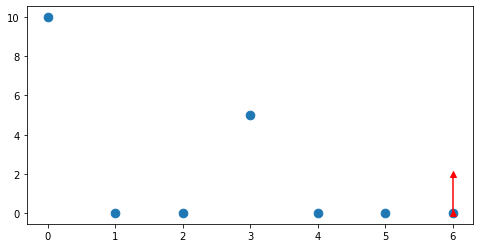

In [13]:
env.render(mode='rgb_array')

In [14]:
env.step(LEFT)
env.render()

'position: 5, remaining rewards: [10  0  0  5  0  0  0], total reward so far: 12.000000000000002, normalized total reward: 0.5217391304347827, steps so far: 5, game done: False'

In [15]:
env.step(LEFT)
env.render()

'position: 4, remaining rewards: [10  0  0  5  0  0  0], total reward so far: 11.000000000000004, normalized total reward: 0.4782608695652175, steps so far: 6, game done: False'

In [16]:
env.step(LEFT)
env.render()

'position: 3, remaining rewards: [10  0  0  0  0  0  0], total reward so far: 15.000000000000004, normalized total reward: 0.6521739130434784, steps so far: 7, game done: False'

In [17]:
env.step(LEFT)
env.render()

'position: 2, remaining rewards: [10  0  0  0  0  0  0], total reward so far: 14.000000000000004, normalized total reward: 0.6086956521739132, steps so far: 8, game done: False'

In [18]:
env.step(LEFT)
env.render()

'position: 1, remaining rewards: [10  0  0  0  0  0  0], total reward so far: 13.000000000000004, normalized total reward: 0.565217391304348, steps so far: 9, game done: False'

In [19]:
env.step(LEFT)
env.render()

'position: 0, remaining rewards: [0 0 0 0 0 0 0], total reward so far: 22.000000000000007, normalized total reward: 0.956521739130435, steps so far: 10, game done: True'

# Train policy with tfagents PpoAgent

### Register with OpenAI Gym

In [0]:
version += 1
env_name = "Line-v{}".format(version)

gym.envs.registration.register(id=env_name, entry_point=LineWorldEnv, max_episode_steps=1000)

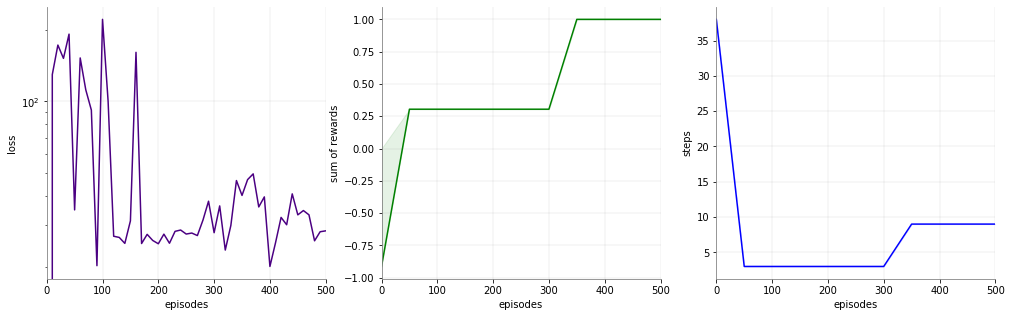

CPU times: user 1min 24s, sys: 1.53 s, total: 1min 26s
Wall time: 1min 23s


In [21]:
%%time

from easyagents.tfagents import PpoAgent
from easyagents.config import Training

training=Training( num_iterations = 50,
                   num_episodes_per_iteration = 10,
                   max_steps_per_episode = 50,
                   num_epochs_per_iteration = 5 )

ppoAgent = PpoAgent(    gym_env_name = env_name,
                        fc_layers=(500,500), 
                        training=training,
                        learning_rate=1e-4
                   )
ppoAgent.train()

In [22]:
ppoAgent.render_episodes(num_episodes=1,mode='ansi')

position: 4, remaining rewards: [10  0  0  5  0  2 15], total reward so far: -1.0, normalized total reward: -0.043478260869565216, steps so far: 1, game done: False
position: 5, remaining rewards: [10  0  0  5  0  0 15], total reward so far: 0.0, normalized total reward: 0.0, steps so far: 2, game done: False
position: 6, remaining rewards: [10  0  0  5  0  0  0], total reward so far: 14.0, normalized total reward: 0.6086956521739131, steps so far: 3, game done: False
position: 5, remaining rewards: [10  0  0  5  0  0  0], total reward so far: 13.000000000000002, normalized total reward: 0.5652173913043479, steps so far: 4, game done: False
position: 4, remaining rewards: [10  0  0  5  0  0  0], total reward so far: 12.000000000000002, normalized total reward: 0.5217391304347827, steps so far: 5, game done: False
position: 3, remaining rewards: [10  0  0  0  0  0  0], total reward so far: 16.000000000000004, normalized total reward: 0.6956521739130436, steps so far: 6, game done: False

### Visualize training and policy (with custom y-limits and movie)

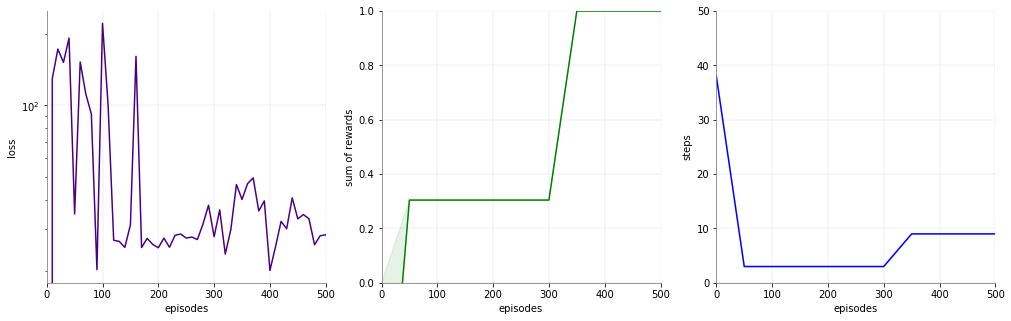

In [23]:
_ = ppoAgent.plot_episodes(ylim=[None,(0,1),(0,50)])

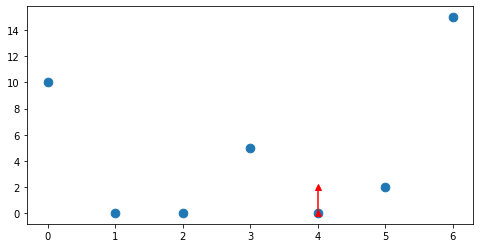

AssertionError: ignored

In [24]:
ppoAgent.render_episodes_to_jupyter(num_episodes=1, fps=1)

# Hands-On 2: Define the observation in a way that allows the agent to train

* You see the agent does not learn with the observation given. Why is that?

* Find an observation that works and impement it in `get_observation`

*  You need to update the `observation_space` to the same shape of your observation at the same time.

* Why does it work? Is this the best observation? How would you even know?

* Do you think this would be sufficient for a real world example? If not, what is missing?

 # STOP HERE

# Generalizing our Environment

* solving a single set up of our line world is not very realistic
* there should be variations to rewards, size, and starting position
* while training with with each episode we could randomly set rewards and starting postition
* different sizes could be simulated by using a fixed max size with a random number of padding entires (e.g -1) at the end


# How does Reinforcement Learning really work?

TODO: Link to slides of presentation for Reinforce|

# Hands-On 3: Make your notebook work with Reinforce

* What parts do you need to change?

* How do the results compare to what you have seen with PPO?

* Can you tweak the parameters (like the size of the neural network) to improve the results?


In [0]:
from easyagents.tfagents import ReinforceAgent